# Proyecto Etapa 1

### Integrantes:
1. Juan Puig - Líder de proyecto
2. Mateo Parra - Líder de datos
3. Juan Garcia - Líder de analitica



#  Detección de Noticias Falsas en Política

Este notebook es parte del primer proyecto de analítica de textos para el curso ISIS-3301 – Inteligencia de Negocios. 

Se busca detectar noticias falsas y extraer palabras clave que apoyen la toma de decisiones en contextos políticos.

La etapa inicial abarca la preparación de datos, el preprocesamiento de textos y la implementación de modelos de aprendizaje automático, incluyendo regresión logística, Random Forest y ... , para clasificar noticias como verdaderas o falsas.


# Entendimiento de datos:

### INSTALACION DE LIBRERIAS

In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
%pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [2]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
%pip install inflect
# Manejo de gráficas
%pip install scikit-plot


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.


In [3]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install pandas-profiling

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.


  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2


# ENTENDIMIENTO DE DATOS 


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB
None

Primeras 5 filas del dataset:
   ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con SÃ¡nchez: 'Europa necesi...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÃN...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda DÃ­az, ERC y EH Bil...   
4  ID      0  Puigdemont: 'No serÃ­a ninguna tragedia una re...   

                                         Descripcion       Fecha  
0  El diario bri

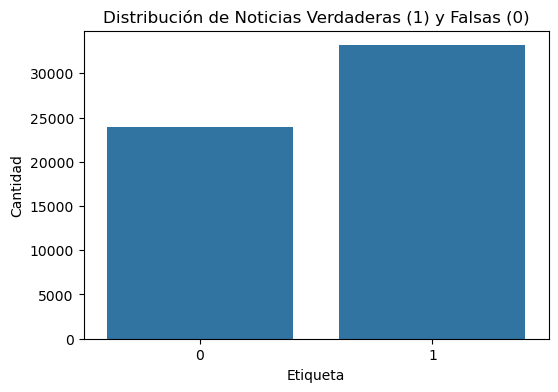


Estadísticas de longitud de títulos:
         count       mean       std  min   25%   50%   75%   max
Label                                                           
0      23905.0  16.507216  4.256811  1.0  14.0  17.0  19.0  37.0
1      33158.0  15.877586  3.739223  1.0  13.0  16.0  19.0  43.0

Estadísticas de longitud de descripciones:
         count       mean        std  min   25%   50%   75%     max
Label                                                              
0      23905.0  40.941686  38.215471  4.0  29.0  37.0  46.0  2470.0
1      33158.0  39.824869  49.102159  4.0  28.0  36.0  43.0  2243.0


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Ruta del archivo CSV (ajusta este path según donde tengas tu archivo)
file_path = "fake_news_spanish.csv"  # Cambia esto a la ruta real de tu archivo

# Cargar el dataset
df = pd.read_csv(file_path, sep=";", encoding="ISO-8859-1")

news = df.copy()
# Mostrar información general del dataset
print("Información general del dataset:")
print(news.info())

# Mostrar las primeras filas para entender la estructura
print("\nPrimeras 5 filas del dataset:")
print(news.head())

# Resumen estadístico de las variables numéricas
print("\nResumen estadístico de variables numéricas:")
print(news.describe())

# ---- Análisis y visualizaciones ----

# 1. Distribución de etiquetas (Label)
label_counts = news['Label'].value_counts()
print("\nDistribución de etiquetas (0 = Falso, 1 = Verdadero):")
print(label_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=news)
plt.title('Distribución de Noticias Verdaderas (1) y Falsas (0)')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad')
plt.show()

# 2. Longitud de títulos y descripciones
news['title_length'] = news['Titulo'].apply(lambda x: len(str(x).split()))
news['desc_length'] = news['Descripcion'].apply(lambda x: len(str(x).split()))

# Estadísticas de longitud
print("\nEstadísticas de longitud de títulos:")
print(news.groupby('Label')['title_length'].describe())
print("\nEstadísticas de longitud de descripciones:")
print(news.groupby('Label')['desc_length'].describe())



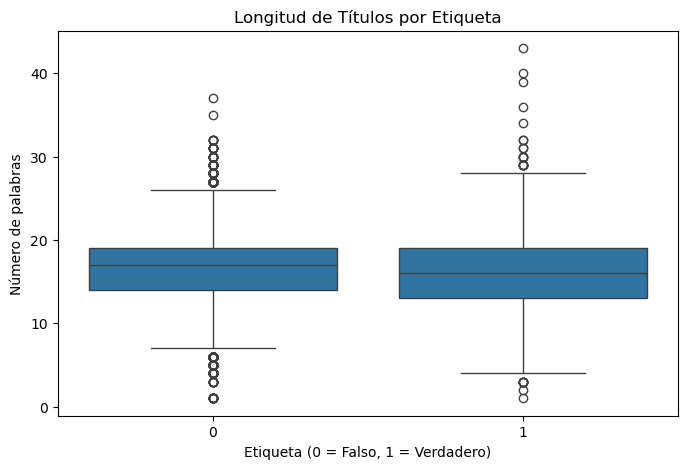

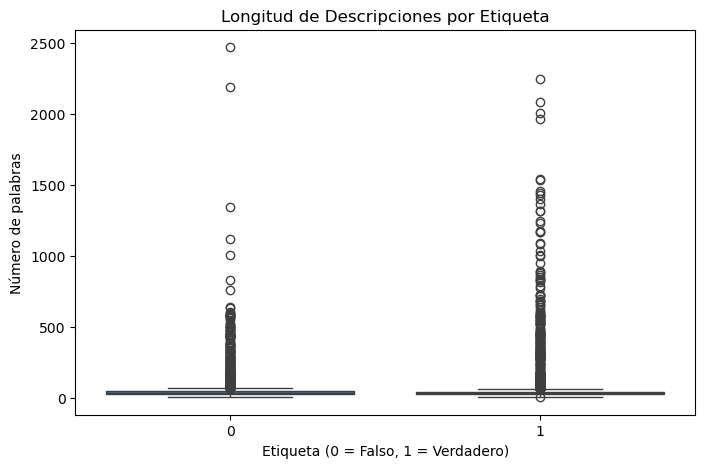

<Figure size 1000x600 with 0 Axes>

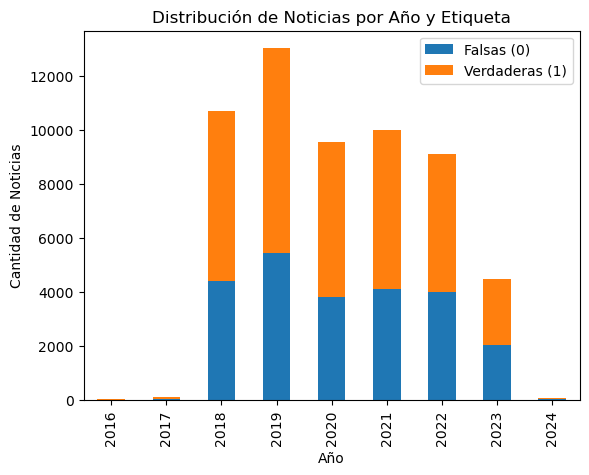


Palabras más frecuentes en títulos de noticias falsas:
[('de', 25935), ('la', 18947), ('el', 16929), ('a', 11588), ('en', 10181), ('y', 9007), ('que', 7221), ('del', 6857), ('los', 5524), ('para', 4387)]

Palabras más frecuentes en títulos de noticias verdaderas:
[('de', 36912), ('la', 27394), ('el', 23488), ('a', 16043), ('en', 14205), ('y', 11988), ('que', 9865), ('del', 9305), ('los', 8769), ('las', 6476)]


In [8]:
# Boxplot de longitud de títulos
plt.figure(figsize=(8, 5))
sns.boxplot(x='Label', y='title_length', data=news)
plt.title('Longitud de Títulos por Etiqueta')
plt.xlabel('Etiqueta (0 = Falso, 1 = Verdadero)')
plt.ylabel('Número de palabras')
plt.show()

# Boxplot de longitud de descripciones
plt.figure(figsize=(8, 5))
sns.boxplot(x='Label', y='desc_length', data=news)
plt.title('Longitud de Descripciones por Etiqueta')
plt.xlabel('Etiqueta (0 = Falso, 1 = Verdadero)')
plt.ylabel('Número de palabras')
plt.show()

# 3. Distribución temporal (por año)
news['Fecha'] = pd.to_datetime(news['Fecha'], format='%d/%m/%Y')
news['Year'] = news['Fecha'].dt.year
year_counts = news.groupby(['Year', 'Label']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', stacked=True)
plt.title('Distribución de Noticias por Año y Etiqueta')
plt.xlabel('Año')
plt.ylabel('Cantidad de Noticias')
plt.legend(['Falsas (0)', 'Verdaderas (1)'])
plt.show()

# 4. Palabras más frecuentes en títulos (separado por etiqueta)
def get_top_words(text_series, n=10):
    # Convertir a str para manejar NaN o valores no-string
    words = ' '.join(text_series.astype(str)).lower().split()
    return Counter(words).most_common(n)

print("\nPalabras más frecuentes en títulos de noticias falsas:")
print(get_top_words(news[news['Label'] == 0]['Titulo']))
print("\nPalabras más frecuentes en títulos de noticias verdaderas:")
print(get_top_words(news[news['Label'] == 1]['Titulo']))

# Opcional: Palabras más frecuentes en descripciones (puede ser pesado, descomenta si lo necesitas)
# print("\nPalabras más frecuentes en descripciones de noticias falsas:")
# print(get_top_words(df[df['Label'] == 0]['Descripcion']))
# print("\nPalabras más frecuentes en descripciones de noticias verdaderas:")
# print(get_top_words(df[df['Label'] == 1]['Descripcion']))

In [9]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID            57063 non-null  object        
 1   Label         57063 non-null  int64         
 2   Titulo        57047 non-null  object        
 3   Descripcion   57063 non-null  object        
 4   Fecha         57063 non-null  datetime64[ns]
 5   title_length  57063 non-null  int64         
 6   desc_length   57063 non-null  int64         
 7   Year          57063 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(3), object(3)
memory usage: 3.3+ MB


Perfilamiento: Una vez analizado el entendimiento, se empiezan a perfilar los datos para la limpieza.

In [10]:
# 1. Completitud: Revisar valores nulos o vacíos
print("=== Completitud ===")
print("Valores nulos por columna:")
print(news.isnull().sum())
print("\nValores vacíos (strings vacíos) por columna:")
print((news == '').sum())

# 2. Duplicidad: Buscar filas duplicadas
print("\n=== Duplicidad ===")
print("Número de filas completamente duplicadas:")
print(news.duplicated().sum())

# Duplicados en columnas específicas
print("\nDuplicados en 'Titulo':")
print(news.duplicated(subset=['Titulo']).sum())
print("Duplicados en 'Descripcion':")
print(news.duplicated(subset=['Descripcion']).sum())
print("Duplicados en 'Titulo' y 'Descripcion' combinados:")
print(news.duplicated(subset=['Titulo', 'Descripcion']).sum())

=== Completitud ===
Valores nulos por columna:
ID               0
Label            0
Titulo          16
Descripcion      0
Fecha            0
title_length     0
desc_length      0
Year             0
dtype: int64

Valores vacíos (strings vacíos) por columna:
ID              0
Label           0
Titulo          0
Descripcion     0
Fecha           0
title_length    0
desc_length     0
Year            0
dtype: int64

=== Duplicidad ===
Número de filas completamente duplicadas:
445

Duplicados en 'Titulo':
5458
Duplicados en 'Descripcion':
7425
Duplicados en 'Titulo' y 'Descripcion' combinados:
450


In [11]:
# 3. Coherencia
print("\n=== Coherencia ===")
# a) Revisar valores en 'Label'
print("Valores únicos en 'Label':")
print(news['Label'].unique())
invalid_labels = news[~news['Label'].isin([0, 1])]
if not invalid_labels.empty:
    print("\nFilas con etiquetas inválidas (no 0 ni 1):")
    print(invalid_labels)
else:
    print("Todas las etiquetas son 0 o 1 (correcto).")


=== Coherencia ===
Valores únicos en 'Label':
[1 0]
Todas las etiquetas son 0 o 1 (correcto).


Ahora se elimina una de las filas duplicadas y las que tienen valores nulos

In [12]:
news = news.drop_duplicates(keep='first')

# Eliminar filas con valores nulos en cualquier columna
news = news.dropna()

In [13]:
# Imprimir el número de filas actuales en 'news'
print("Número de filas actuales en el dataset 'news':", len(news))

Número de filas actuales en el dataset 'news': 56602


In [14]:
import pandas as pd
import unicodedata
import re

# Funciones de limpieza adaptadas
def remove_non_ascii(text):
    """Remove non-ASCII characters from a string"""
    if pd.isna(text):  # Manejar valores nulos
        return ""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def to_lowercase(text):
    """Convert all characters to lowercase"""
    if pd.isna(text):
        return ""
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from a string"""
    if pd.isna(text):
        return ""
    return re.sub(r'[^\w\s]', '', text)

def replace_numbers(text):
    """Replace *NUMBER* placeholders with 'numero'"""
    if pd.isna(text):
        return ""
    return re.sub(r'\*NUMBER\*', 'numero', text)

def preprocessing(text):
    """Apply all preprocessing steps to a string"""
    text = replace_numbers(text)  # Primero reemplazar *NUMBER*
    text = remove_non_ascii(text)
    text = to_lowercase(text)
    text = remove_punctuation(text)
    return text.strip()  # Eliminar espacios sobrantes

# Aplicar limpieza a las columnas 'Titulo' y 'Descripcion'
news['Titulo_clean'] = news['Titulo'].apply(preprocessing)
news['Descripcion_clean'] = news['Descripcion'].apply(preprocessing)

# Eliminar la columna 'ID' ya que es redundante (siempre es 'ID')
news = news.drop(columns=['ID'])

# Mostrar las primeras filas para verificar el resultado
print("Primeras 5 filas del dataset limpio:")
print(news[['Label', 'Titulo_clean', 'Descripcion_clean', 'Fecha']].head())

# Imprimir el número de filas después de la limpieza
print("\nNúmero de filas actuales en el dataset 'news' después de limpieza:", len(news))

Primeras 5 filas del dataset limpio:
   Label                                       Titulo_clean  \
0      1  the guardian va con sanchez europa necesita qu...   
1      0  revelan que el gobierno negocio la liberacian ...   
2      1  el ahora o nunca de joan fuster sobre el estat...   
3      1  iglesias alienta a yolanda daaz erc y eh bildu...   
4      0  puigdemont no seraa ninguna tragedia una repet...   

                                   Descripcion_clean      Fecha  
0  el diario britanico publica3 este pasado jueve... 2023-06-02  
1  revelan que el gobierno negocio la liberacian ... 2023-10-01  
2  el valencianismo convoca en castella3 su fiest... 2022-04-25  
3  en polatica igual que hay que negociar con los... 2022-01-03  
4  en una entrevista en el punt avui el lader de ... 2018-03-09  

Número de filas actuales en el dataset 'news' después de limpieza: 56602


In [15]:
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords en español (solo la primera vez)
nltk.download('stopwords')

# Obtener las stopwords en español
stop_words = set(stopwords.words('spanish'))

def remove_stopwords(text):
    """Remove stopwords from a string"""
    if pd.isna(text):  # Manejar valores nulos
        return ""
    # Dividir el texto en palabras, filtrar stopwords y volver a unir
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Aplicar la eliminación de stopwords a las columnas limpias
news['Titulo_clean_no_stop'] = news['Titulo_clean'].apply(remove_stopwords)
news['Descripcion_clean_no_stop'] = news['Descripcion_clean'].apply(remove_stopwords)

# Mostrar las primeras filas para verificar el resultado
print("Primeras 5 filas del dataset con stopwords eliminadas:")
print(news[['Label', 'Titulo_clean_no_stop', 'Descripcion_clean_no_stop', 'Fecha']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Primeras 5 filas del dataset con stopwords eliminadas:
   Label                               Titulo_clean_no_stop  \
0      1  the guardian va sanchez europa necesita apuest...   
1      0  revelan gobierno negocio liberacian mireles ca...   
2      1  ahora nunca joan fuster estatuto valenciano cu...   
3      1  iglesias alienta yolanda daaz erc eh bildu neg...   
4      0  puigdemont seraa ninguna tragedia repeticia3n ...   

                           Descripcion_clean_no_stop      Fecha  
0  diario britanico publica3 pasado jueves editor... 2023-06-02  
1  revelan gobierno negocio liberacian mireles ca... 2023-10-01  
2  valencianismo convoca castella3 fiesta grande ... 2022-04-25  
3  polatica igual negociar empresarios negociar g... 2022-01-03  
4  entrevista punt avui lader jxcat desdramatizad... 2018-03-09  


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# Descargar el tokenizador punkt (solo la primera vez)
nltk.download('punkt')

# Tokenizar las columnas limpias sin stopwords
news['titulo_tokens'] = news['Titulo_clean_no_stop'].apply(word_tokenize)
news['descripcion_tokens'] = news['Descripcion_clean_no_stop'].apply(word_tokenize)

# Mostrar las primeras filas para verificar el resultado
print("Primeras 5 filas del dataset con tokenización:")
print(news[['Label', 'titulo_tokens', 'descripcion_tokens', 'Fecha']].head())

# Información básica del dataset después de tokenizar
print("\nDimensiones del dataset después de tokenización:", news.shape)
print("\nInformación de la columna 'titulo_tokens':")
print(news['titulo_tokens'].info())
print("\nInformación de la columna 'descripcion_tokens':")
print(news['descripcion_tokens'].info())

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Primeras 5 filas del dataset con tokenización:
   Label                                      titulo_tokens  \
0      1  [the, guardian, va, sanchez, europa, necesita,...   
1      0  [revelan, gobierno, negocio, liberacian, mirel...   
2      1  [ahora, nunca, joan, fuster, estatuto, valenci...   
3      1  [iglesias, alienta, yolanda, daaz, erc, eh, bi...   
4      0  [puigdemont, seraa, ninguna, tragedia, repetic...   

                                  descripcion_tokens      Fecha  
0  [diario, britanico, publica3, pasado, jueves, ... 2023-06-02  
1  [revelan, gobierno, negocio, liberacian, mirel... 2023-10-01  
2  [valencianismo, convoca, castella3, fiesta, gr... 2022-04-25  
3  [polatica, igual, negociar, empresarios, negoc... 2022-01-03  
4  [entrevista, punt, avui, lader, jxcat, desdram... 2018-03-09  

Dimensiones del dataset después de tokenización: (56602, 13)

Información de la columna 'titulo_tokens':
<class 'pandas.core.series.Series'>
Index: 56602 entries, 0 to 57062
Ser

## Lematizar

In [17]:
%pip install spacy
!python -m spacy download es_core_news_sm

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ----------- ---------------------------- 3.7/12.9 MB 21.8 MB/s eta 0:00:01
     ------------------------------ -------- 10.0/12.9 MB 25.9 MB/s eta 0:00:01
     --------------------------------------  12.8/12.9 MB 26.8 MB/s eta 0:00:01
     --------------------------------------  12.8/12.9 MB 26.8 MB/s eta 0:00:01
     --------------------------------------  12.8/12.9 MB 26.8 MB/s eta 0:00:01
     --------------------------------------  12.8/12.9 MB 26.8 MB/s eta 0:00:01
     ---------------------------------------- 12.9/12.9 MB 8.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [18]:
import pandas as pd
import spacy


# Cargar el modelo en español de spaCy
nlp = spacy.load('es_core_news_sm')



def lemmatize_tokens(token_list):
    """Lemmatize a list of tokens"""
    if not token_list or pd.isna(token_list).any():  # Verificar si la lista está vacía o tiene NaN
        return []
    # Convertir la lista de tokens en un string para pasarlo a spaCy
    text = ' '.join(token_list)
    doc = nlp(text)
    return [token.lemma_ for token in doc]

# Aplicar stemming y lematización a 'Titulo' y 'Descripcion'
news['titulo_lemmas'] = news['titulo_tokens'].apply(lemmatize_tokens)
news['descripcion_lemmas'] = news['descripcion_tokens'].apply(lemmatize_tokens)


# Mostrar resultados
print(news[['Label', 'titulo_lemmas', 'descripcion_lemmas', 'Fecha']].head())

   Label                                      titulo_lemmas  \
0      1  [the, guardiar, ir, sanchez, europa, necesitar...   
1      0  [revelar, gobierno, negocio, liberaciar, mirel...   
2      1  [ahora, nunca, joan, fuster, estatuto, valenci...   
3      1  [iglesia, alentar, yolanda, daaz, erc, eh, bil...   
4      0  [puigdemont, seraa, ninguno, tragedia, repetic...   

                                  descripcion_lemmas      Fecha  
0  [diario, britanico, publica3, pasado, jueves, ... 2023-06-02  
1  [revelar, gobierno, negocio, liberaciar, mirel... 2023-10-01  
2  [valencianismo, convocar, castella3, fiesta, g... 2022-04-25  
3  [polaticar, igual, negociar, empresario, negoc... 2022-01-03  
4  [entrevista, punt, avui, lader, jxcat , desdra... 2018-03-09  


# Vectorizacion

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer

# Unir los tokens lematizados en strings para cada fila
news['titulo_text'] = news['titulo_lemmas'].apply(lambda x: ' '.join(map(str, x)))
news['descripcion_text'] = news['descripcion_lemmas'].apply(lambda x: ' '.join(map(str, x)))

# Separar variable predictora (Label) y textos a utilizar
X_titulo, y_data = news['titulo_text'], news['Label']
X_descripcion = news['descripcion_text']  # También procesaremos las descripciones

# Transformación binaria 1 a 1 (presencia/ausencia de palabras) usando HashingVectorizer
hashing = HashingVectorizer(binary=True, n_features=2**18)  # Adjust n_features as needed
X_titulo_dummy = hashing.fit_transform(X_titulo)
X_descripcion_dummy = hashing.fit_transform(X_descripcion)
print("Shape de X_titulo_dummy:", X_titulo_dummy.shape)
print("Shape de X_descripcion_dummy:", X_descripcion_dummy.shape)
print("Ejemplo de X_titulo_dummy (primera fila):", X_titulo_dummy.toarray()[0])

# Conteo de palabras presentes usando HashingVectorizer
hashing_count = HashingVectorizer(n_features=2**18)  # Adjust n_features as needed
X_titulo_count = hashing_count.fit_transform(X_titulo)
X_descripcion_count = hashing_count.fit_transform(X_descripcion)
print("Shape de X_titulo_count:", X_titulo_count.shape)
print("Shape de X_descripcion_count:", X_descripcion_count.shape)
print("Ejemplo de X_titulo_count (primera fila):", X_titulo_count.toarray()[0])

# Transformación TF-IDF
tf_idf = TfidfVectorizer()
X_titulo_tf_idf = tf_idf.fit_transform(X_titulo)
X_descripcion_tf_idf = tf_idf.fit_transform(X_descripcion)
print("Shape de X_titulo_tf_idf:", X_titulo_tf_idf.shape)
print("Shape de X_descripcion_tf_idf:", X_descripcion_tf_idf.shape)
print("Ejemplo de X_titulo_tf_idf (primera fila):", X_titulo_tf_idf.toarray()[0])


Shape de X_titulo_dummy: (56602, 16384)
Shape de X_descripcion_dummy: (56602, 16384)
Ejemplo de X_titulo_dummy (primera fila):   (0, 410)	0.3333333333333333
  (0, 842)	0.3333333333333333
  (0, 4080)	0.3333333333333333
  (0, 4139)	0.3333333333333333
  (0, 5209)	0.3333333333333333
  (0, 8350)	0.3333333333333333
  (0, 8636)	0.3333333333333333
  (0, 14979)	0.3333333333333333
  (0, 15550)	0.3333333333333333
Shape de X_titulo_tf_idf: (56602, 10000)
Shape de X_descripcion_tf_idf: (56602, 10000)
Ejemplo de X_titulo_tf_idf (primera fila):   (0, 9241)	0.37570656748331294
  (0, 4832)	0.4439264154366522
  (0, 5531)	0.24256253461760582
  (0, 8626)	0.18385424779285933
  (0, 4060)	0.2960844915150179
  (0, 6635)	0.3287488659765131
  (0, 1039)	0.35774008407774494
  (0, 2903)	0.2198737640577864
  (0, 4568)	0.4439264154366522


# Graficar matriz

In [ ]:
# Convertir subsecciones a DataFrame para graficar (primeras 10 filas y 20 columnas)
n_rows, n_cols = 10, 20
dummy_df = pd.DataFrame(X_titulo_dummy[:n_rows, :n_cols].toarray(), columns=dummy.get_feature_names_out()[:n_cols])
count_df = pd.DataFrame(X_titulo_count[:n_rows, :n_cols].toarray(), columns=count.get_feature_names_out()[:n_cols])
tfidf_df = pd.DataFrame(X_titulo_tf_idf[:n_rows, :n_cols].toarray(), columns=tf_idf.get_feature_names_out()[:n_cols])

# Graficar matrices como heatmaps
plt.figure(figsize=(15, 10))

# Matriz binaria (dummy)
plt.subplot(3, 1, 1)
sns.heatmap(dummy_df, cmap="Blues", annot=True, fmt="d", cbar=True)
plt.title("Matriz Binaria (CountVectorizer binary=True) - Primeras 10 filas y 20 palabras")
plt.xlabel("Palabras")
plt.ylabel("Noticias")

# Matriz de conteo
plt.subplot(3, 1, 2)
sns.heatmap(count_df, cmap="YlGnBu", annot=True, fmt="d", cbar=True)
plt.title("Matriz de Conteo (CountVectorizer) - Primeras 10 filas y 20 palabras")
plt.xlabel("Palabras")
plt.ylabel("Noticias")

# Matriz TF-IDF
plt.subplot(3, 1, 3)
sns.heatmap(tfidf_df, cmap="OrRd", annot=True, fmt=".2f", cbar=True)
plt.title("Matriz TF-IDF (TfidfVectorizer) - Primeras 10 filas y 20 palabras")
plt.xlabel("Palabras")
plt.ylabel("Noticias")

plt.tight_layout()
plt.show()

NameError: name 'X_titulo_count' is not defined

# MODELOS

## Modelo 1: Regresión Logistica


### Realizado por Juan Puig

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [27]:
# Combinar títulos y descripciones lematizados en un solo texto
news['combined_text'] = news.apply(lambda row: ' '.join(row['titulo_lemmas'] + row['descripcion_lemmas']), axis=1)

# Separar features (X) y target (y)
X_data = news['combined_text']
y_data = news['Label']

# Dividir en 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Transformar texto con TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Entrenar modelo de regresión logística
model = LogisticRegression(random_state=42)
model.fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_tfidf)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Falsa (0)', 'Verdadera (1)'])

# Mostrar resultados
print("Precisión del modelo:", accuracy)
print("\nReporte de clasificación:\n", report)

Precisión del modelo: 0.8887580236735174

Reporte de clasificación:
                precision    recall  f1-score   support

    Falsa (0)       0.94      0.78      0.86      7185
Verdadera (1)       0.86      0.97      0.91      9796

     accuracy                           0.89     16981
    macro avg       0.90      0.87      0.88     16981
 weighted avg       0.90      0.89      0.89     16981



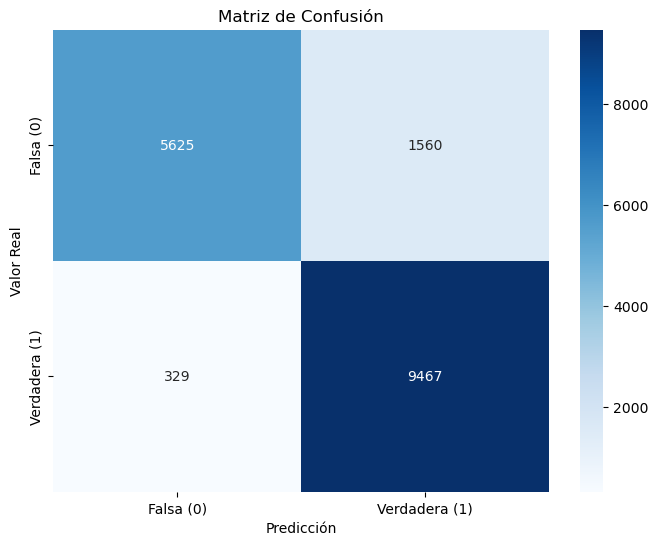

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa (0)', 'Verdadera (1)'], yticklabels=['Falsa (0)', 'Verdadera (1)'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

### Test

In [ ]:
import pandas as pd

# Cargar el archivo de prueba desde el path
file_path_test = "fake_news_test.csv"
df_test = pd.read_csv(file_path, sep=";", encoding="ISO-8859-1")
news_test = df_test.copy()

news_test['combined_text'] = (news_test['Titulo'].fillna('') + ' ' + news_test['Descripcion'].fillna('')).str.strip()

# Transformar el texto con el TF-IDF ya ajustado (definido en el entrenamiento)
X_test_new = news_test['combined_text']
X_test_new_tfidf = tfidf.transform(X_test_new)

# Predecir con el modelo ya entrenado
y_pred_new = model.predict(X_test_new_tfidf)

# Agregar las predicciones al DataFrame
news_test['Predicted_Label'] = y_pred_new

# Mostrar las predicciones
print("Predicciones para fake_news_test.csv:")
print(news_test[['Titulo', 'Descripcion', 'Fecha', 'Predicted_Label']])



NameError: name 'tfidf' is not defined

In [ ]:
# Contar cuántas noticias se asignaron como 1 (verdaderas) y 0 (falsas)
label_counts = news_test['Predicted_Label'].value_counts()
print("Noticias asignadas como Falsas (0):", label_counts.get(0, 0))
print("Noticias asignadas como Verdaderas (1):", label_counts.get(1, 0))

KeyError: 'Predicted_Label'

# Modelo 2: Random Forest

### Realizado por Mateo Parra

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer




X_data = news['combined_text']
y_data = news['Label']

# Dividir en 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Transformar el texto en vectores numéricos usando TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Crear y entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test_tfidf)

# Evaluar el desempeño del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Falsa (0)', 'Verdadera (1)'])

print("Precisión del modelo Random Forest:", accuracy)
print("\nReporte de clasificación:\n", report)


Precisión del modelo Random Forest: 0.9153171191331488

Reporte de clasificación:
                precision    recall  f1-score   support

    Falsa (0)       0.93      0.86      0.90      7185
Verdadera (1)       0.90      0.95      0.93      9796

     accuracy                           0.92     16981
    macro avg       0.92      0.91      0.91     16981
 weighted avg       0.92      0.92      0.91     16981



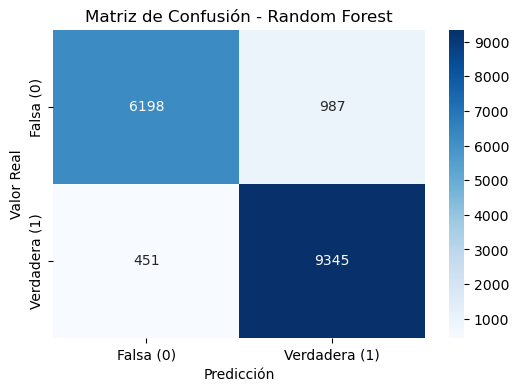

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Falsa (0)', 'Verdadera (1)'], 
            yticklabels=['Falsa (0)', 'Verdadera (1)'])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()





### Test

In [ ]:
import pandas as pd

# Cargar el archivo de test
test = pd.read_csv("fake_news_test.csv", sep=";", encoding="ISO-8859-1")


test['Titulo_clean'] = test['Titulo'].apply(preprocessing)
test['Descripcion_clean'] = test['Descripcion'].apply(preprocessing)

test['combined_text'] = test['Titulo_clean'] + " " + test['Descripcion_clean']


X_test_new = tfidf.transform(test['combined_text'])


predictions = rf_model.predict(X_test_new)


test['Predicted_Label'] = predictions


print(test[['Titulo', 'Predicted_Label']].head())


test.to_csv("fake_news_test_predictions.csv", index=False)


                                              Titulo  Predicted_Label
0  La mesa del congreso censura un encuentro inte...                0
1  La brecha digital que dificulta el acceso de a...                1
2  PP apremia al EQUO a presentar una propuesta d...                0
3  De soberano garante de la democracia a rey cor...                1
4  El Gobierno aprobarÃ¡ este martes detraer los ...                1
